In [36]:
import torch
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
import matplotlib.pyplot as plt
import seaborn as sns

from train import train_uivi
from tqdm import tqdm
from ui_encoder import UIEncoder

# UIVI with a banana-shaped distribution

## 1.  Train

In [37]:
device = 'cpu'
# parameters of banana distribution
mean = torch.tensor([0,0], requires_grad=False).to(device)
cov = torch.tensor([[1,0.9], [0.9, 1]], requires_grad=False).to(device)
model = UIEncoder(mean = mean, cov =  cov, num_eps_samples = 3, dim_eps = 3, dim_z = 2, latent_dim = 50, T = 5, L = 5)

In [31]:
model, losses_mod, losses_ent = train_uivi(model, lr = 1e-3,  num_iter = 10000, num_hmc_samples = 5 )

 22%|██▏       | 2187/10000 [00:33<01:58, 65.73it/s, accept_prob=0.867, grad_z=1.36, log_qz=0.072, loss=1.5, status=running]     

Text(0.5, 1.0, ' ELBO $\\uparrow$')

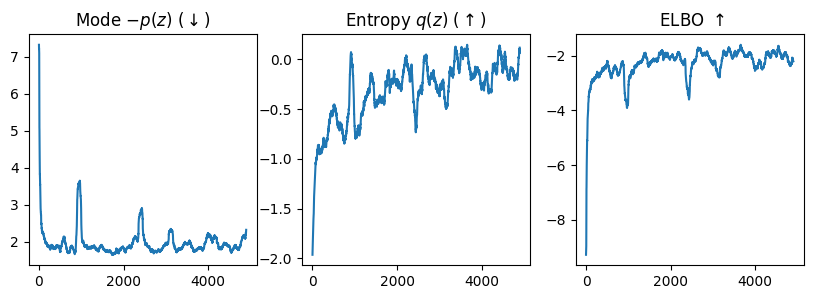

In [32]:
# plot training losses
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (10,3)) 
window_size = 100
mod =  sliding_window_view(losses_mod, window_shape = window_size)
ent = sliding_window_view(losses_ent, window_shape = window_size)

axs[0].plot(np.mean(mod, axis = -1))
axs[0].set_title(r'Mode $- p(z)$ ($\downarrow$)')

axs[1].plot(np.mean(ent, axis = -1))
axs[1].set_title(r'Entropy $q(z)$ ($\uparrow$)' )

axs[2].plot(- np.mean(mod - ent, axis = -1))
axs[2].set_title(r' ELBO $\uparrow$')

## 2. Predict

In [33]:
m, n = 100, 100
lims_x = (-2.5, 2.5) # support of the PDF
lims_y = (-8, 2)
xx, yy = np.meshgrid(np.linspace(*lims_x, m), np.linspace(*lims_y, n))
points = np.stack((xx, yy), axis=-1)
flat_points = torch.tensor(points.reshape(-1, 2))
encoder_true = UIEncoder(mean = mean, cov =  cov, num_eps_samples =  flat_points.shape[0], dim_eps = 3, dim_z = 2)
log_probs = encoder_true.log_p_z(flat_points)
log_probs = np.asarray(log_probs.clone().detach().reshape(m, n))

In [34]:
# Generate samples from fitted model
z_samples = []
mus = []
model.eval()
for _ in tqdm(range(300)):
  with torch.no_grad():
    mu, z_sample, _, sigma = model.forward()
  z_samples.append(z_sample)
  mus.append(mu)

z_samples = torch.stack(z_samples).detach().cpu().numpy().reshape(-1, 2)
mus = torch.stack(mus).detach().cpu().numpy().reshape(-1,2)

100%|██████████| 300/300 [00:00<00:00, 23347.52it/s]


/var/folders/73/tcv3sgb138b9cqckw4zk9r5h0000gn/T/ipykernel_8338/1842655755.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  axs[0].contour(xx, yy, np.exp(log_probs), levels=10, cmap='Blues', alpha = 0.8)
/var/folders/73/tcv3sgb138b9cqckw4zk9r5h0000gn/T/ipykernel_8338/1842655755.py:7: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  axs[1].contour(xx, yy, np.exp(log_probs), levels=10, cmap='Blues', alpha = 0.8)


Text(0.5, 1.0, 'Contour')

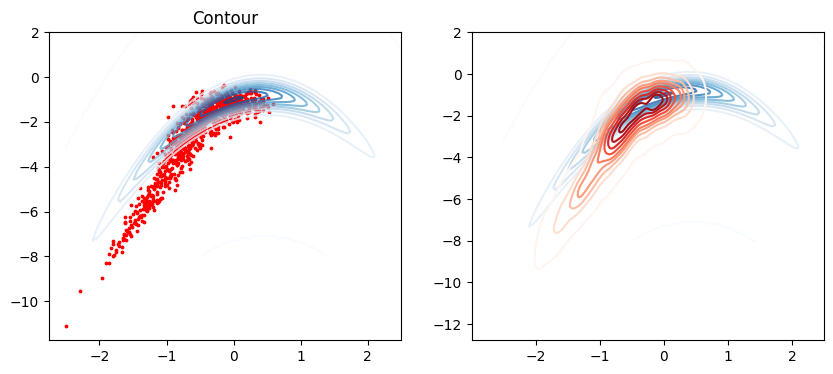

In [35]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (10,4)) 

axs[0].contour(xx, yy, np.exp(log_probs), levels=10, cmap='Blues', alpha = 0.8)
axs[0].scatter(z_samples[:, 0], z_samples[:, 1], color='red', s = 3, alpha = 1)
axs[0].set_title('Samples')

axs[1].contour(xx, yy, np.exp(log_probs), levels=10, cmap='Blues', alpha = 0.8)
sns.kdeplot(x=z_samples[:,0], y=z_samples[:,1], fill=False, cmap = "Reds",  thresh=0.01, levels=10, ax = axs[1])
axs[0].set_title('Contour')
